In [20]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import json
import pandas as pd

import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.bayesian_generator as baycon
import lib.ext.baycon.baycon.time_measurement as time_measurement
from lib.ext.baycon.common.DataAnalyzer import *
from lib.ext.baycon.common.Target import Target
from lib.ext.baycon.common.ScoreCalculator import ScoreCalculator
from lib.score_calculator_kmeans import ScoreCalculatorKmeans
from lib.score_calculator_model_agnostic import ScoreCalculatorModelAgnostic

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Axes: >

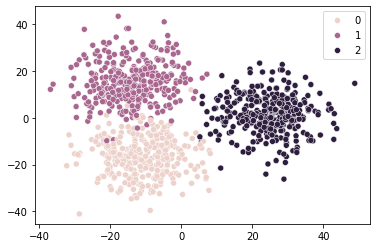

In [21]:
X, y = make_blobs(centers=3, cluster_std=8, n_features=20, n_samples=1000)

pca = PCA(n_components=2)
embed_X = pca.fit_transform(X)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y)

In [22]:
modes = ['classic_baycon', 'kmeans', 'model_agnostic']
run_mode = modes[2]


if run_mode == modes[0]:
    model = RandomForestClassifier()
elif run_mode == modes[1]:
    model = KMeans(n_clusters=3)
elif run_mode == modes[2]:
    model = KMeans(n_clusters=3)
    # model = SpectralClustering(n_clusters=3)
else:
    raise("Invalid baycon mode")
model.fit(X, y)
pred = model.predict(X)
pred = [str(l) for l in pred]
stacked = np.column_stack((X, pred))
df = pd.DataFrame(stacked, columns=[f'x{i+1}' for i in range(X.shape[1])]+['label'], dtype=float)
df

/home/jacob/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

<Axes: >

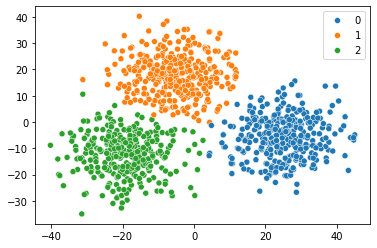

In [ ]:
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=pred)

In [ ]:
def execute(df, model, target, initial_instance_index, categorical_features=[], actionable_features=[]):
    y = df[[target.target_feature()]].values.ravel()
    X = df.drop([target.target_feature()], axis=1).values
    feature_names = df.columns[df.columns != target.target_feature()]

    run = 0
    data_analyzer = DataAnalyzer(X, y, feature_names, target, categorical_features, actionable_features)
    X, y = data_analyzer.data()
    initial_instance = X[initial_instance_index]
    initial_prediction = y[initial_instance_index]

    print("--- Executing... Initial Instance: {} Target: {} Run: {} ---".format(
        initial_instance_index,
        target.target_value_as_string(),
        run
    ))
    target_cluster_center = None
    min_target_cluster_distance = None
    max_target_cluster_distance = None

    # Initialize ScoreCalculator Classification / Clustering
    initial_instance_f = initial_instance.astype(float)   # np operations need same type object to compute!
    if target.target_type() == Target.TYPE_CLASSIFICATION or target.target_type() == Target.TYPE_REGRESSION:
        score_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
    elif target.target_type() == Target.TYPE_CLUSTERING_KMEANS:
        # point_pred = int(model.predict([X[initial_instance_index]])[0])
        target_cluster_center = model.cluster_centers_[target._target_value]
        
        target_cluster_indices = np.where(y == target._target_value)

        min_target_cluster_distance = np.min([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X[target_cluster_indices]])
        # max_target_cluster_distance = np.max([np.linalg.norm(i-target_cluster_center) for i in X])

        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorKmeans(initial_instance, initial_prediction, target, data_analyzer, base_calculator, min_target_cluster_distance, max_target_cluster_distance, target_cluster_center)
    elif target.target_type() == Target.TYPE_MODEL_AGNOSTIC:
        amount_of_coreset_points = 1000

        base_calculator = ScoreCalculator(initial_instance, initial_prediction, target, data_analyzer)
        score_calculator = ScoreCalculatorModelAgnostic(initial_instance, initial_prediction, target, data_analyzer, base_calculator, amount_of_coreset_points, X, y)

    counterfactuals, _ranker = baycon.run(initial_instance_f, initial_prediction, target, data_analyzer, model, score_calculator)
    predictions = np.array([])
    try:
        predictions = model.predict(counterfactuals)
    except ValueError:
        pass
    output = {
        "initial_instance": initial_instance.tolist(),
        "initial_prediction": str(initial_prediction),
        "categorical_features": categorical_features,
        "actionable_features": actionable_features,
        "target_type": target.target_type(),
        "target_value": target.target_value(),
        "target_feature": target.target_feature(),
        "total_time": str(time_measurement.total_time),
        "time_to_first_solution": str(time_measurement.time_to_first_solution),
        "time_to_best_solution": str(time_measurement.time_to_best_solution),
        "counterfactuals": counterfactuals.tolist(),
        "predictions": predictions.tolist()
    }

    # output_filename = "{}_{}_{}_{}_{}_{}.json".format("bcg", dataset_name, initial_instance_index,
    #                                                   target.target_value_as_string(), model_name, run)
    # with open(output_filename, 'w') as outfile:
    #     json.dump(output, outfile)
    # print("--- Finished: saved file {}\n".format(output_filename))
    
    return counterfactuals, predictions, initial_instance, initial_prediction, target_cluster_center, min_target_cluster_distance, max_target_cluster_distance #, data_analyzer, ranker, model


In [ ]:
point_idx = 0
point_pred = int(model.predict([X[point_idx]])[0])
print("Point prediction: ", point_pred, type(point_pred))
if run_mode == modes[0]:
    t = Target(target_type="classification", target_feature="label", target_value=1)
elif run_mode == modes[1]:
    t = Target(target_type="clustering_kmeans", target_feature="label", target_value=1)
elif run_mode == modes[2]:
    t = Target(target_type="model_agnostic", target_feature="label", target_value=1)

cf, _predictions, _initial_instance, _initial_prediction, target_center, min_center_dist, max_center_dist = execute(df, model, t, point_idx)

Point prediction:  0 <class 'int'>
--- Executing... Initial Instance: 0 Target: 1 Run: 0 ---
--- Step 0: Load internal objects ---
--- Step 1: Generate initial neighbours ---
Generated initial neighbours: (642) CFs (628)
Re-training surrogate model with data size: 642
--- Step 2: Explore neighbourhood ---
--- epoch 1 ----
Generating neighbors for 1 near best instances
Generated neighbours: (3) Unique overall (3)
Generated random instances: (3252)
Predicted top: 20 Counterfactuals: 20
Found new best [-20.12680335  -3.54239159  -6.30960842   6.57807065  14.61069764
 -18.77905167   8.37112212   6.97611939  -2.94222246  16.84479982
  12.41511754  -2.6030618   16.16994668   9.05324179   3.57796924
  -6.66932297  -5.22061788 -16.65551896   4.93165468  -4.91077168], with fitness score 0.2483 (X 0.96807 Y 0.27 F 0.95), oversampling
Known alternatives: 662
Best instance score 0.2483 (X 0.96807 Y 0.27 F 0.95), found on epoch: 1
Re-training surrogate model with data size: 672
--- epoch 2 ----
Gen

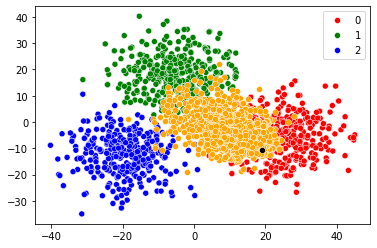

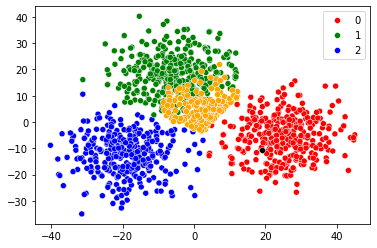

In [ ]:

embed_cf = pca.transform(cf)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')
plt.show()

filtered_cfs = [i for i in cf if model.predict(i.reshape(1,-1)) == t._target_value]
embed_cf = pca.transform(filtered_cfs)
sns.scatterplot(x=embed_X[:,0], y=embed_X[:,1], hue=pred, palette=['red','green','blue'])
sns.scatterplot(x=embed_cf[:,0], y=embed_cf[:,1], color='orange')
sns.scatterplot(x=embed_X[[0],0], y=embed_X[[0],1], color='black')
plt.show()

if run_mode == modes[1]:
    center_distances = [np.linalg.norm(i-target_center) for i in cf]
    y_score = 1 - ((center_distances - min_center_dist)/(max_center_dist - min_center_dist))
    y_score[y_score < 0] = 0
    y_score[y_score > 1] = 1
    print(y_score)